# **STOCK MARKET PREDICTION USING NUMERICAL AND TEXTUAL ANALYSIS**
**Siddharth Trivedi**

https://github.com/SidT12/Stock-market-prediction

Datasets used:


1.   Historical stock prices (S&P BSE SENSEX) : https://finance.yahoo.com/
2.   Textual News Headlines: https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/DPQMQH/P2Z4PM



# Importing libraries, downloading and reading datasets

In [3]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# reading the datasets into pandas
stock_price = pd.read_csv('BSESN.csv')


In [5]:
stock_headlines = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/DPQMQH/P2Z4PM')

In [6]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [7]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [8]:
len(stock_price), len(stock_headlines)

(3912, 3297172)

In [9]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

# Feature engineering for stock prices

In [10]:
stock_price.dropna(axis=0, inplace=True) #dropping null entries

In [11]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0
...,...,...,...,...,...
2020-10-26,40145.500000,40649.761719,40724.398438,39948.289063,10100.0
2020-10-27,40522.101563,40199.078125,40555.601563,39978.390625,13900.0
2020-10-28,39922.460938,40664.351563,40664.351563,39774.601563,29400.0


# Feature engineering for stock headlines

In [12]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


# Combining both datasets

In [13]:

# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur..."
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S..."
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f..."
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M..."
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,..."
...,...,...,...,...,...,...
2020-06-24,34868.980469,35679.738281,35706.550781,34794.929688,26600.0,I never thought I had a voice until today: Vid...
2020-06-25,34842.101563,34525.390625,35081.609375,34499.781250,24600.0,Truck firms look for new export markets to sel...
2020-06-26,35171.269531,35144.781250,35254.878906,34910.339844,24800.0,Containment zone residents slam high prices ch...
2020-06-29,34961.519531,34926.949219,35032.359375,34662.058594,18300.0,6 hot and stylish bikini looks of Katrina Kaif...


# Performing Sentiment Analysis

In [14]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur...",,,,
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",,,,
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f...",,,,
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M...",,,,
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",,,,


In [15]:

# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores......')
# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

# displaying the stock data
stock_data.head()


Start calculating sentiment scores......
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2005-01-03,6679.200195,6626.490234,6684.220215,6626.490234,12000.0,"ICAI compliments minister,Partnering for futur...",-0.9731,0.114,0.802,0.084
2005-01-04,6651.009766,6683.560059,6696.310059,6640.899902,16600.0,"Arab Gaze,Uniform Laws,Tsunami Relief,Double S...",-0.7600,0.062,0.880,0.059
2005-01-05,6458.839844,6628.890137,6629.979980,6337.609863,24000.0,"Quake Rumours,Mishap reunites 12-yr boy with f...",-0.9757,0.110,0.805,0.085
2005-01-06,6367.390137,6447.270020,6481.229980,6325.359863,22200.0,"Doon School preparing to admit girls?,Market M...",0.9417,0.073,0.825,0.102
2005-01-07,6420.459961,6374.189941,6440.169922,6348.750000,17800.0,"Faultline Repair,No Parade; Please,NRI Spirit,...",-0.9456,0.087,0.836,0.076


In [16]:

# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,6679.200195,-0.9731,0.114,0.802,0.084,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,-0.7600,0.062,0.880,0.059,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,-0.9757,0.110,0.805,0.085,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,0.9417,0.073,0.825,0.102,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,-0.9456,0.087,0.836,0.076,6374.189941,6440.169922,6348.750000,17800.0


# Feature engineering of combined data

In [20]:
stock_data.shape

(3797, 9)

In [21]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [22]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3.797000e+03
mean,21684.928516,-0.903121,0.128848,0.783971,0.087204,21709.947115,21839.237563,21537.699962,1.006863e+05
std,9076.435960,0.403484,0.021321,0.027023,0.015794,9095.508228,9111.481098,9051.906633,1.213891e+06
min,6102.740234,-1.000000,0.038000,0.635000,0.029000,6093.660156,6174.000000,6069.330078,8.000000e+02
25%,15446.150391,-0.999800,0.116000,0.766000,0.077000,15446.820313,15580.860352,15323.049805,1.060000e+04
50%,19355.259766,-0.999500,0.130000,0.781000,0.087000,19376.000000,19487.019531,19237.259766,1.440000e+04
75%,28092.789063,-0.997200,0.143000,0.800000,0.097000,28112.359375,28216.640625,27943.910156,2.020000e+04
max,41952.628906,1.000000,0.217000,0.901000,0.253000,42263.000000,42273.871094,41850.289063,3.181510e+07


In [23]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3797 entries, 2005-01-03 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     3797 non-null   float64
 1   compound  3797 non-null   float64
 2   negative  3797 non-null   float64
 3   neutral   3797 non-null   float64
 4   positive  3797 non-null   float64
 5   Open      3797 non-null   float64
 6   High      3797 non-null   float64
 7   Low       3797 non-null   float64
 8   Volume    3797 non-null   float64
dtypes: float64(9)
memory usage: 296.6 KB


# Analysis of Stock Data

Text(0, 0.5, 'Close Price (INR)')

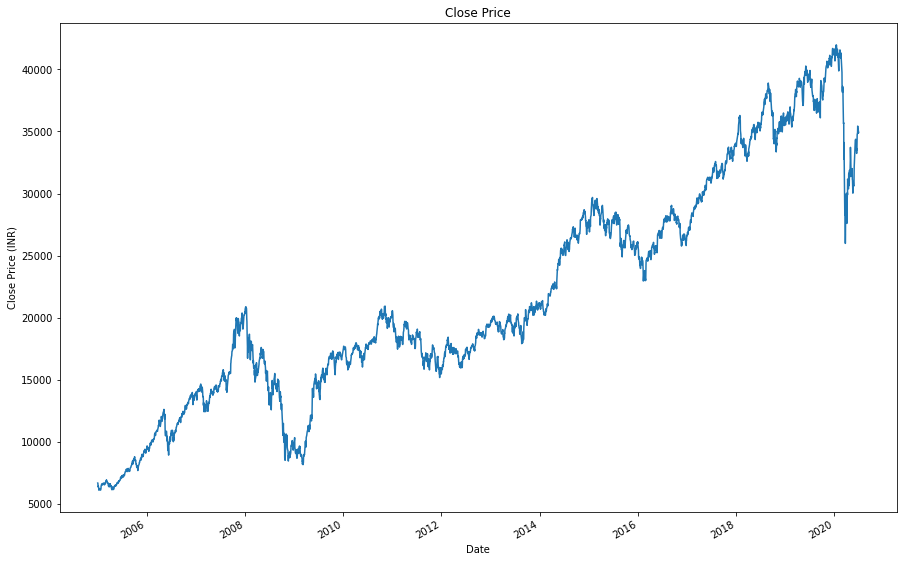

In [25]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [26]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-11,6444.044294,-0.389857,0.090429,0.821571,0.088000,6502.588658,6532.984305,6396.397112,17428.571429
2005-01-12,6361.692871,-0.387243,0.089429,0.821857,0.088714,6448.854353,6472.911412,6316.945661,18685.714286
2005-01-13,6300.271484,-0.350286,0.094714,0.810286,0.094857,6370.924317,6408.145717,6245.109933,19200.000000
2005-01-14,6259.554339,-0.099329,0.086714,0.821286,0.091857,6314.285714,6353.775739,6217.462821,18371.428571


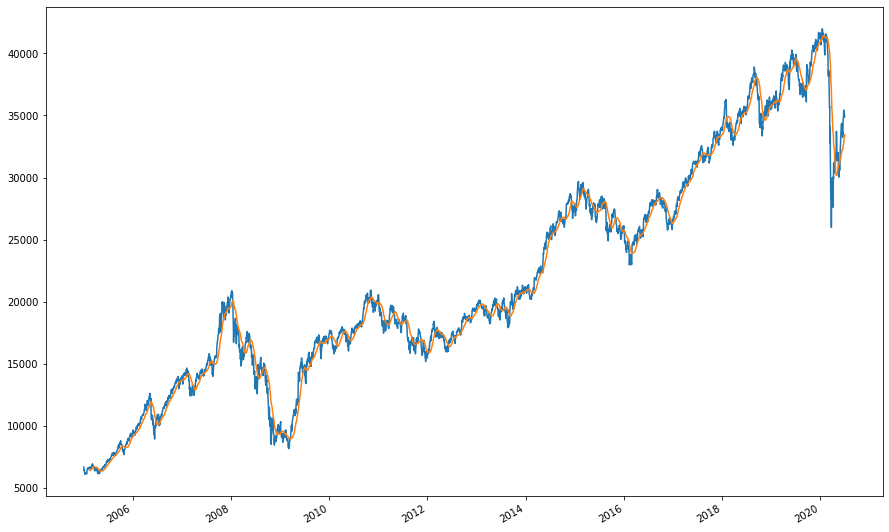

In [28]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [29]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2005-01-03,6679.200195,-0.9731,0.114,0.802,0.084,6626.490234,6684.220215,6626.490234,12000.0
2005-01-04,6651.009766,-0.7600,0.062,0.880,0.059,6683.560059,6696.310059,6640.899902,16600.0
2005-01-05,6458.839844,-0.9757,0.110,0.805,0.085,6628.890137,6629.979980,6337.609863,24000.0
2005-01-06,6367.390137,0.9417,0.073,0.825,0.102,6447.270020,6481.229980,6325.359863,22200.0
2005-01-07,6420.459961,-0.9456,0.087,0.836,0.076,6374.189941,6440.169922,6348.750000,17800.0
...,...,...,...,...,...,...,...,...,...
2020-06-24,34868.980469,-0.9997,0.115,0.811,0.074,35679.738281,35706.550781,34794.929688,26600.0
2020-06-25,34842.101563,-0.9999,0.126,0.820,0.054,34525.390625,35081.609375,34499.781250,24600.0
2020-06-26,35171.269531,-0.9999,0.149,0.766,0.085,35144.781250,35254.878906,34910.339844,24800.0
2020-06-29,34961.519531,-0.9997,0.119,0.804,0.078,34926.949219,35032.359375,34662.058594,18300.0


# Preparing Data for Modelling

In [30]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3036
Number of records in Test Data: 761


In [31]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2005-01-04     6651.009766
2005-01-05     6458.839844
2005-01-06     6367.390137
2005-01-07     6420.459961
2005-01-10     6308.540039
                  ...     
2020-06-24    34868.980469
2020-06-25    34842.101563
2020-06-26    35171.269531
2020-06-29    34961.519531
2020-06-30    34915.800781
Name: Close, Length: 3796, dtype: float64

In [32]:

# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2005-01-04,6651.009766,6458.839844,-0.7600,-0.9757,16600.0,6683.560059,6696.310059,6640.899902
2005-01-05,6458.839844,6367.390137,-0.9757,0.9417,24000.0,6628.890137,6629.979980,6337.609863
2005-01-06,6367.390137,6420.459961,0.9417,-0.9456,22200.0,6447.270020,6481.229980,6325.359863
2005-01-07,6420.459961,6308.540039,-0.9456,0.9673,17800.0,6374.189941,6440.169922,6348.750000
2005-01-10,6308.540039,6222.870117,0.9673,-0.9836,13200.0,6440.330078,6469.089844,6286.850098
2005-01-11,6222.870117,6102.740234,-0.9836,-0.9548,16200.0,6317.390137,6329.890137,6208.819824
2005-01-12,6102.740234,6221.060059,-0.9548,-0.5013,20800.0,6250.350098,6263.709961,6070.330078
2005-01-13,6221.060059,6173.819824,-0.5013,0.7810,20200.0,6138.049805,6242.950195,6138.049805
2005-01-14,6173.819824,6194.069824,0.7810,-0.9925,18200.0,6232.419922,6249.390137,6144.080078
2005-01-17,6194.069824,6192.350098,-0.9925,-0.9990,19000.0,6202.740234,6232.970215,6087.549805


In [33]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

2005-01-04     6458.839844
2005-01-05     6367.390137
2005-01-06     6420.459961
2005-01-07     6308.540039
2005-01-10     6222.870117
                  ...     
2020-06-23    34868.980469
2020-06-24    34842.101563
2020-06-25    35171.269531
2020-06-26    34961.519531
2020-06-29    34915.800781
Name: close_price_shifted, Length: 3795, dtype: float64

In [34]:

# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2005-01-04,6651.009766,-0.7600,-0.9757,16600.0,6683.560059,6696.310059,6640.899902
2005-01-05,6458.839844,-0.9757,0.9417,24000.0,6628.890137,6629.979980,6337.609863
2005-01-06,6367.390137,0.9417,-0.9456,22200.0,6447.270020,6481.229980,6325.359863
2005-01-07,6420.459961,-0.9456,0.9673,17800.0,6374.189941,6440.169922,6348.750000
2005-01-10,6308.540039,0.9673,-0.9836,13200.0,6440.330078,6469.089844,6286.850098
...,...,...,...,...,...,...,...
2020-06-23,35430.429688,-0.9999,-0.9997,25200.0,35015.730469,35482.160156,34843.691406
2020-06-24,34868.980469,-0.9997,-0.9999,26600.0,35679.738281,35706.550781,34794.929688
2020-06-25,34842.101563,-0.9999,-0.9999,24600.0,34525.390625,35081.609375,34499.781250
2020-06-26,35171.269531,-0.9999,-0.9997,24800.0,35144.781250,35254.878906,34910.339844


# Scaling the features and dependent variable

In [35]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.96941304, -0.76      , -0.9757    , ..., -0.96738122,
         -0.97106305, -0.96805173],
        [-0.98013385, -0.9757    ,  0.9417    , ..., -0.97040422,
         -0.97473786, -0.98500433],
        [-0.98523566,  0.9417    , -0.9456    , ..., -0.98044698,
         -0.98297889, -0.98568905],
        ...,
        [ 0.60331663, -0.9999    , -0.9999    , ...,  0.57214539,
          0.60153532,  0.58913858],
        [ 0.62168031, -0.9999    , -0.9997    , ...,  0.60639488,
          0.61113478,  0.61208702],
        [ 0.60997874, -0.9997    , -0.9998    , ...,  0.59434976,
          0.59880678,  0.59820918]]), array([[-0.98013385],
        [-0.98523566],
        [-0.982275  ],
        ...,
        [ 0.62168031],
        [ 0.60997874],
        [ 0.60742817]]))

# Dividing the data into training and test set

In [36]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3036, 7) and y: (3036, 1)
Number of rows and columns in the Test set X: (758, 7) and y: (758, 1)


In [37]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3036, 7, 1)
Shape of Test set X: (758, 7, 1)


# Modelling

In [38]:

# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [39]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
304/304 [==============================] - 6s 18ms/step - loss: 0.0305 - val_loss: 0.0282
Epoch 2/10
304/304 [==============================] - 4s 14ms/step - loss: 0.0023 - val_loss: 3.4666e-04
Epoch 3/10
304/304 [==============================] - 4s 15ms/step - loss: 0.0014 - val_loss: 2.7857e-04
Epoch 4/10
304/304 [==============================] - 4s 15ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/10
304/304 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 3.7385e-04
Epoch 6/10
304/304 [==============================] - 4s 15ms/step - loss: 0.0011 - val_loss: 2.7777e-04
Epoch 7/10
304/304 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 3.7695e-04
Epoch 8/10
304/304 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/10
304/304 [==============================] - 4s 14ms/step - loss: 9.7575e-04 - val_loss: 3.3596e-04
Epoch 10/10
304/304 [==============================] - 4s 14ms/

In [40]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


# Performing Predictions

In [41]:
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[30455.547],
       [30800.28 ],
       [30941.666],
       [31052.857],
       [31107.244]], dtype=float32)

# Evaluating the Model

In [42]:

# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

758/758 [==============================] - 2s 2ms/step - loss: 8.5229e-04
Train Loss = 0.0003
Test Loss = 0.0009


In [43]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 35727.3824


In [45]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 35727.3824


In [46]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

# Plotting the Predicted data against Test data

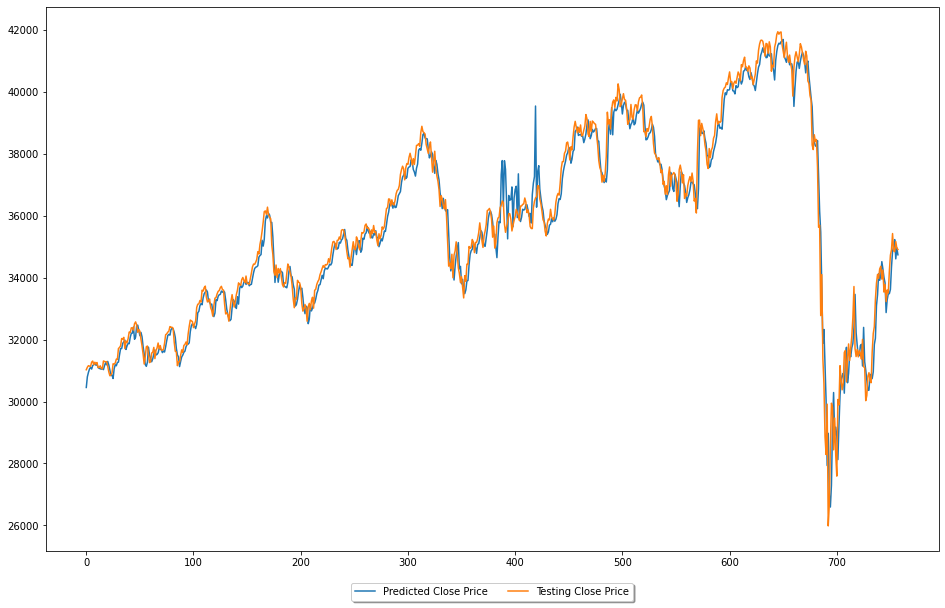

In [47]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()